In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mayavi import mlab
from math import factorial
import os

In [864]:
### Render parameters and functions ###

#Mayavi parameters
mlab.options.offscreen = True
#mlab.init_notebook('png',width=500, height=500)

def make_scene(shape, contour, substrate, shape_only=False):
    #Builds the whole scene
    #Optional: builds only the spherical shape
    
    fig = mlab.figure(bgcolor=(1, 1, 1), fgcolor=(0, 0, 0),size=(400, 400))
    
    #Optional: builds only the shape
    if shape_only:
        #Build the shape
        mlab.mesh(shape[0], shape[1], shape[2], color=(0.8, 0.8, 0.8))

    else:
        #Build the shape
        mlab.mesh(shape[0], shape[1], shape[2], color=(0.8, 0.8, 0.8))

        #Build the contact line
        mlab.plot3d(contour[0], contour[1], contour[2], tube_radius=0.01, color = (0, 0, 0))

        #Build the substrate
        angle = np.deg2rad((-15, 105))
        d = 5
        mlab.mesh(substrate[0] - d*np.cos(angle[0])*np.sin(angle[1]), 
                  substrate[1] - d*np.sin(angle[0])*np.sin(angle[1]), 
                  substrate[2] - d*np.cos(angle[1]), opacity = 0.2)

    #Camera parameters
    fig.scene.light_manager.light_mode = 'vtk'
    fig.scene.parallel_projection = True
    fig.scene.camera.parallel_scale = 2
    
    return fig

#Rendering functions
def plot_views(title):
    #Renders the three views side by side in the notebook (low-resolution, fast)
    
    d=4
    #3D angled view
    mlab.view(0-15, 105, distance=d, focalpoint=(0,0,0))
    angled_view = mlab.screenshot(mode='rgba', antialiased=True)

    #Side-view projection
    mlab.view(0, 90, distance=d, focalpoint=(0,0,0))
    side_view = mlab.screenshot(mode='rgba', antialiased=True)

    #Top-view projection
    mlab.view(0, 0, distance=d, focalpoint=(0,0,0))
    top_view = mlab.screenshot(mode='rgba', antialiased=True)
    
    f, axs = plt.subplots(1,3) 
    #plt.rcParams["figure.figsize"] = (20,5)
    plt.tight_layout()
    for ax in axs: ax.axis('off')

    axs[0].imshow(angled_view)
    axs[1].imshow(side_view)
    axs[2].imshow(top_view)
    
    f.suptitle(title, fontsize=16)
    
    return f

def save_views(fig,path, prefix, definition):
    #Renders and saves the three views in specified directory (arbitrary resolution).
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    d=4
    #3D angled view
    mlab.view(0-15, 105, distance=d, focalpoint=(0,0,0))
    mlab.savefig(path + prefix + "-3D.png", size = (definition, definition), figure=fig)

    #Side-view projection
    mlab.view(0, 90, distance=d, focalpoint=(0,0,0))
    mlab.savefig(path + prefix + "-side.png", size = (definition, definition), figure=fig)

    #Top-view projection
    mlab.view(0, 0, distance=d, focalpoint=(0,0,0))
    mlab.savefig(path + prefix + "-top.png", size = (definition, definition), figure=fig)
    
    return

In [865]:
def harmonic(k, l, phi, theta):
    #Returns the value of the spherical harmonic (k,l) at (phi, theta)
    
    return np.sqrt((2*l+1)*factorial(k-l)/(4*np.pi*factorial(k+l)))*(
           np.cos(l*phi)*sp.special.lpmn(l,k,np.cos(np.pi-theta))[0][l,k])

def make_coordinates(N):
    #Returns the angular mesh, uniformly distributed
    
    phi = np.linspace(0, 2 * np.pi, N, endpoint=True)
    theta = np.linspace(np.pi, 0, N, endpoint=True)
    
    return(phi, theta)

def make_substrate(surface_height, L):
    #Creates the substrate surface at the given level
    
    Xa = np.linspace(-L,L,10)
    Ya = np.linspace(-L,L,10)
    Xs = np.outer(Xa, np.ones(np.size(Ya)))
    Ys = np.outer(np.ones(np.size(Xa)), Ya)
    Zs = np.zeros((np.size(Xa), np.size(Ya))) + surface_height
    
    return (Xs, Ys, Zs)

def make_shape(phi_array, theta_array, modes, amplitudes, rotation, phase):
    #Returns the shape modes superposition, evaluated on the provided (phi, theta) mesh
    
    #Resting shape
    R0=1 
    R = R0*np.ones((len(phi_array), len(theta_array)))
    
    nb = len(amplitudes)
    for m in range(nb):
        (n,l) = modes[m]
        k=n+l
        H = np.zeros(R.shape)
        for i in range(len(phi_array)):
            for j in range(len(theta_array)):
                phi = phi_array[i] - phases[m] - rotation
                theta = theta_array[j] 
                H[i,j] = harmonic(k,l,phi,theta)
                
        a = amplitudes[m]
        R += phase*R0*a*H
        
        X = np.copy(R)*np.outer(np.cos(phi_array), np.sin(theta_array))
        Y = np.copy(R)*np.outer(np.sin(phi_array), np.sin(theta_array))
        Z = np.copy(R)*np.outer(np.ones(np.size(phi_array)), np.cos(theta_array))
    
    return (X,Y,Z)


def crop_shape(phi, theta, spherical_shape, surface_height, modes, amplitudes, rotation, phase):
    #Crops the shape mode and reconstructs the contact surface
    
    (X,Y,Z) = spherical_shape
    R = np.sqrt(X**2 + Y**2 + Z**2)
    X_cropped = np.copy(X)
    Y_cropped = np.copy(Y)
    Z_cropped = np.copy(Z)
    
    #Contour line of the contact surface
    X_contour = np.zeros(phi.shape)
    Y_contour = np.zeros(phi.shape)
    Z_contour = surface_height*np.ones(phi.shape) 

    for i in range(len(Z)):
        for j in range(len(Z[0])):
            if Z[i,j]>surface_height:
                theta_interp = sp.interpolate.CubicSpline(Z[i][j-3:j+3],theta[j-3:j+3])(surface_height)
                contour_interp = make_shape([phi[i]], [theta_interp], modes, amplitudes, rotation, phase)
                R_interp = np.sqrt(contour_interp[0]**2 + contour_interp[1]**2 + contour_interp[2]**2)[0,0]
                X_cropped[i,j] = contour_interp[0][0,0]
                Y_cropped[i,j] = contour_interp[1][0,0]
                Z_cropped[i,j] = surface_height

                X_contour[i] = X_cropped[i,j]
                Y_contour[i] = Y_cropped[i,j]

                for k in range(j+1,len(Z[0])):
                    Z_cropped[i,k] = surface_height
                    if R[i,k]*np.sin(theta[k]) > R_interp*np.sin(theta_interp):
                        X_cropped[i,k] = X_cropped[i,j]
                        Y_cropped[i,k] = Y_cropped[i,j]
                break
                
    return ((X_cropped, Y_cropped, Z_cropped), (X_contour, Y_contour, Z_contour))

In [1097]:
### Spherical shape maker ###

#Creating the angular mesh
phi, theta = make_coordinates(200)

#Input shape parameters
modes=[(0,5),(5,0)]
amplitudes=[0.5,1]
phases=[0,0]
rotation=3*np.pi/5
phase=-1

#Calculating the shape
shape = make_shape(phi, theta, modes, amplitudes, rotation, phase)

In [1098]:
### Sessile shape calculation ###

#Creating the substrate
surface_height = 0.5
surface_width = 1.5
substrate = make_substrate(surface_height, surface_width)

#Calculating the cropped sessile shape
cropped_shape, contour = crop_shape(phi, theta, shape, surface_height, modes, amplitudes, rotation, phase)

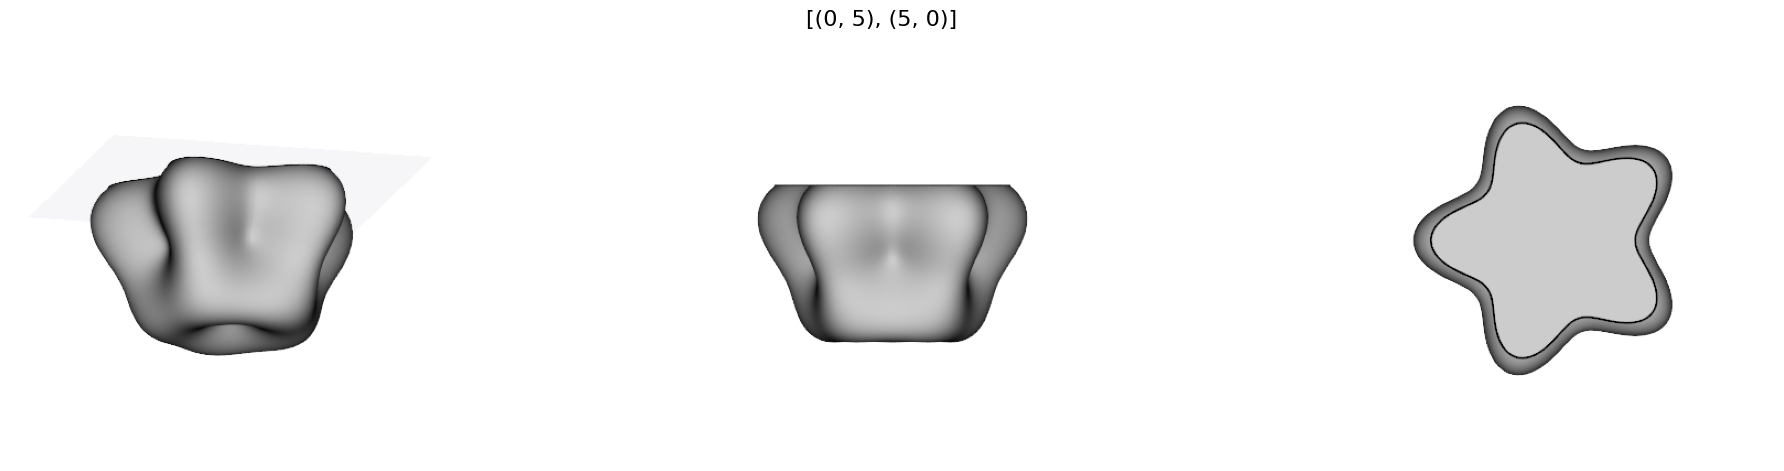

In [1099]:
### Inline low-res render (fast) ###

fig = make_scene(cropped_shape, contour, substrate)

#Spherical shape only render alternative
#fig = make_scene(shape, [], [], shape_only=True)

title = str(modes)
lowres_plot = plot_views(title)

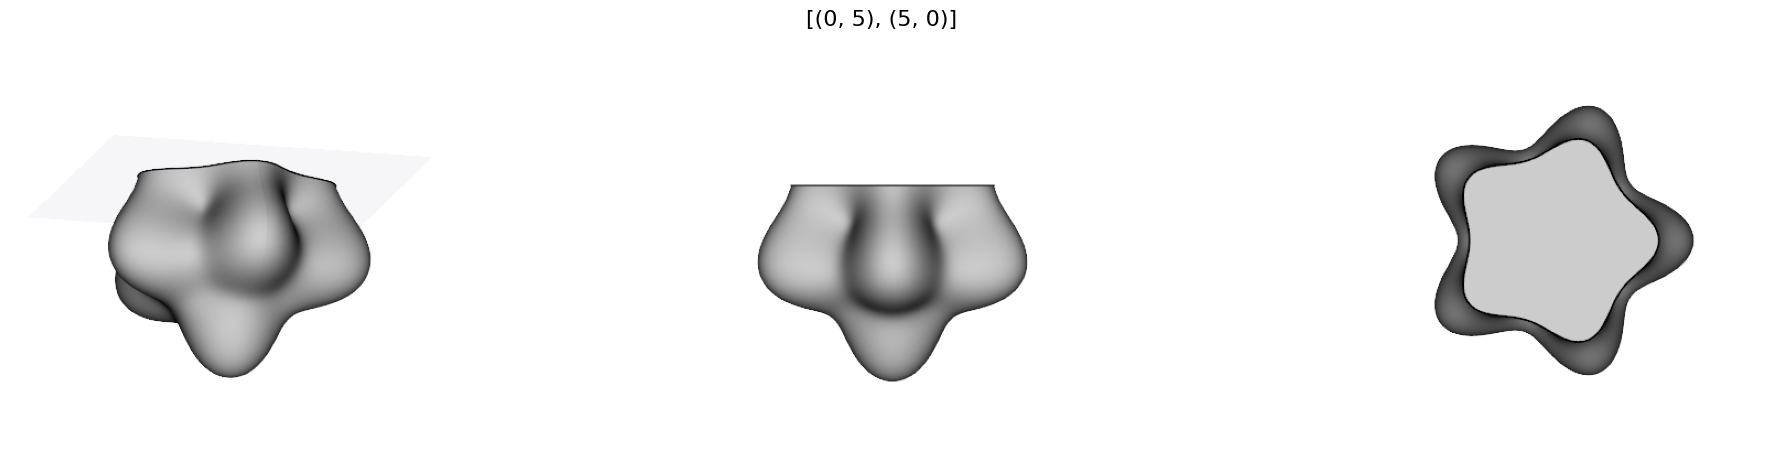

In [1096]:
lowres_plot

In [32]:
### High-resolution render in a png file ###

save_views(fig, "test\\", "test_render", 2000)

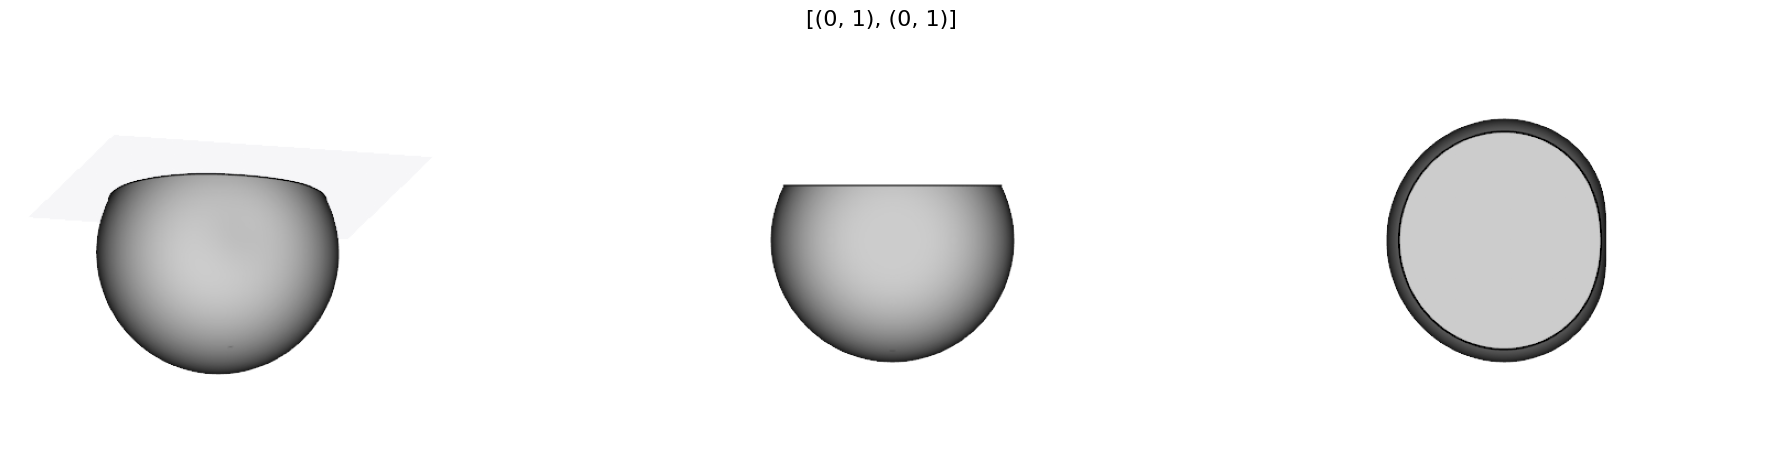

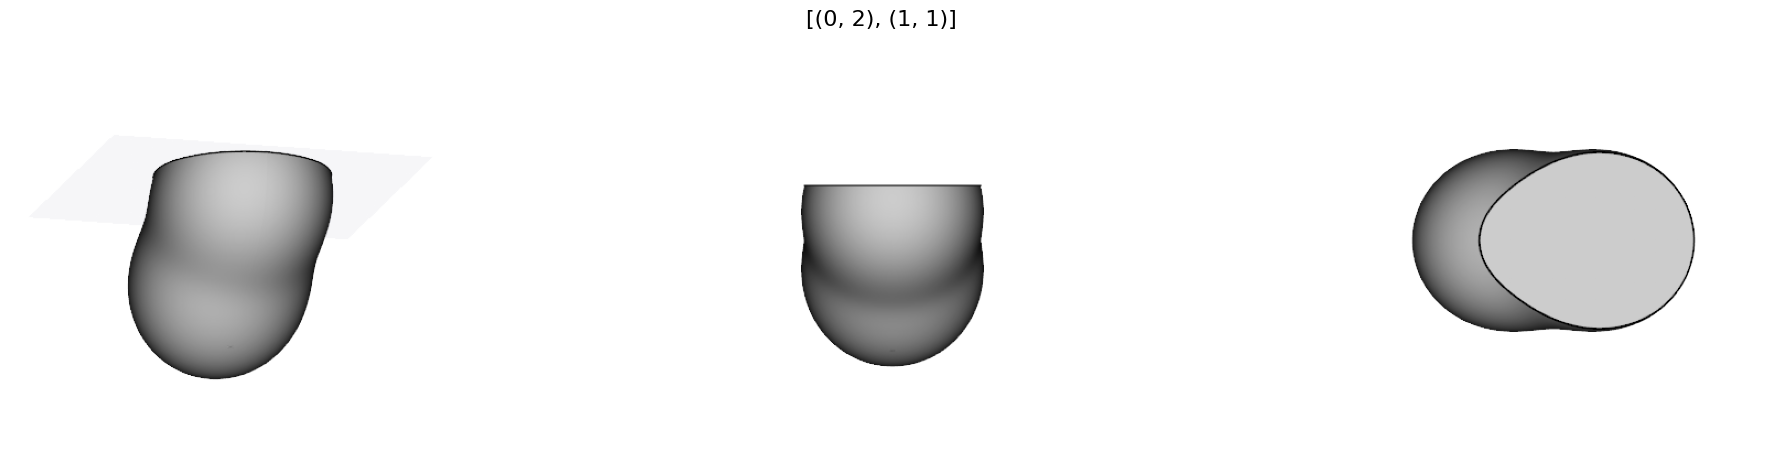

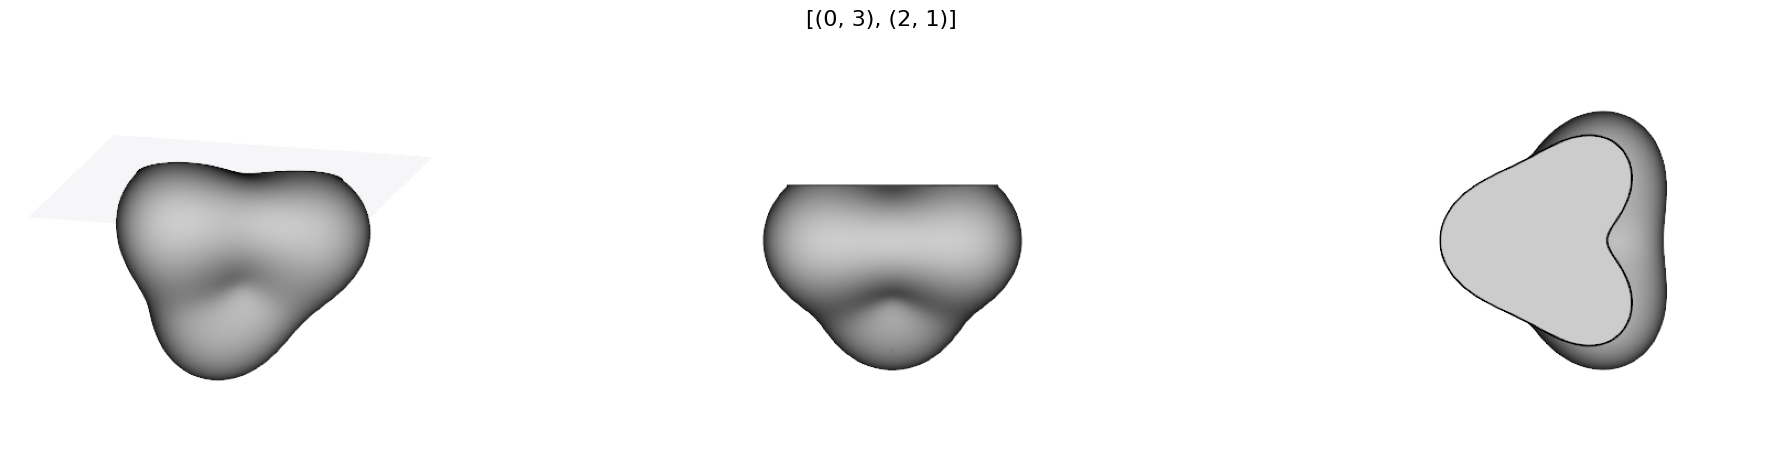

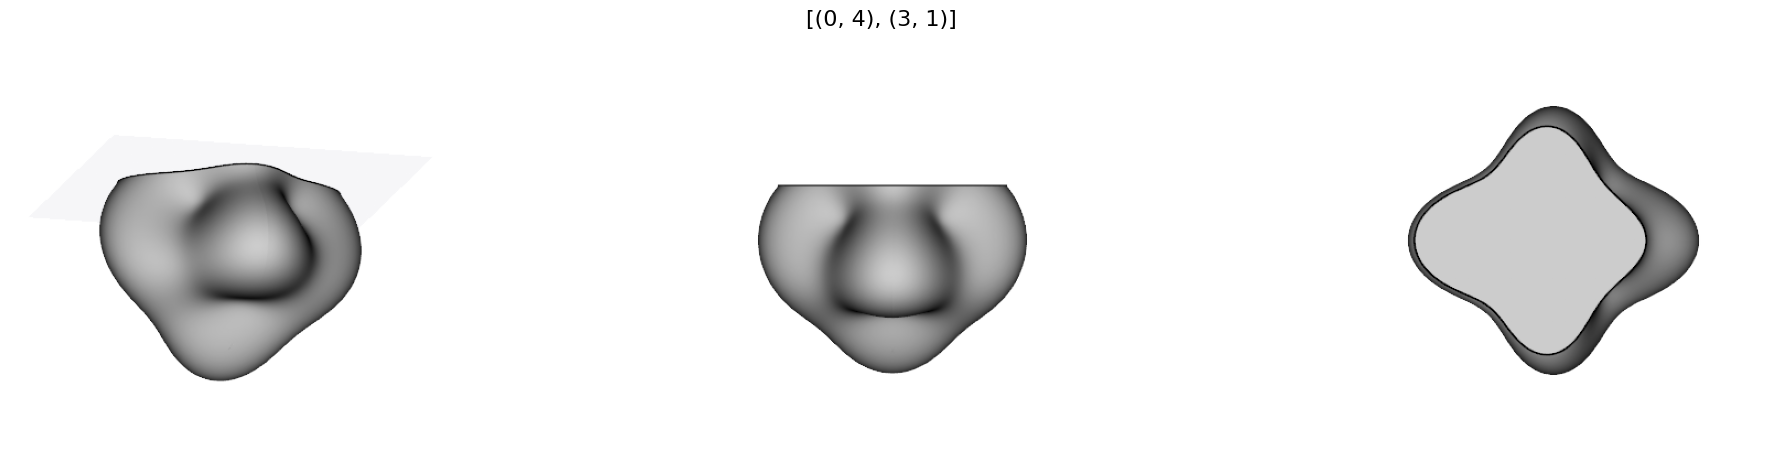

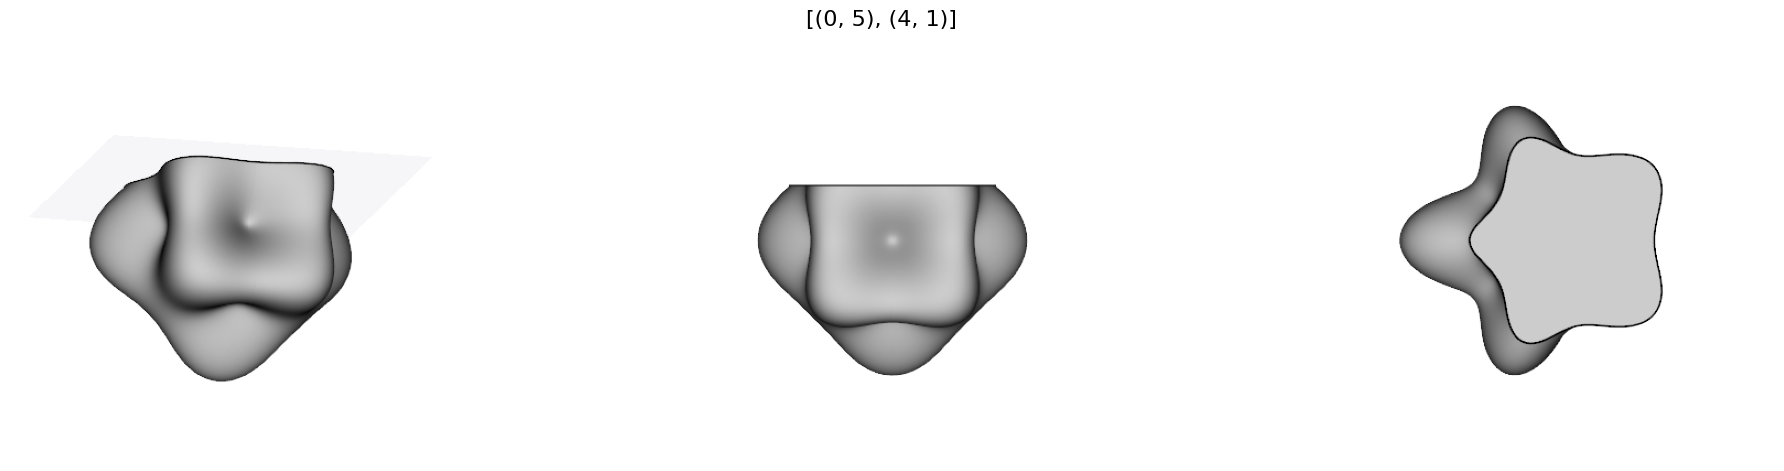

In [126]:
### Consecutive shape modes ###

phi, theta = make_coordinates(200)
rotation = 0
phase = 1
for k in range(1,6):
    modes = [(0,k),(k-1,1)]
    amplitudes = [0.5,1]
    shape = make_shape(phi, theta, modes, amplitudes, rotation, phase)
    substrate = make_substrate(surface_height, surface_width)
    cropped_shape, contour = crop_shape(phi, theta, shape, surface_height, modes, amplitudes, rotation, phase)
    fig = make_scene(cropped_shape, contour, substrate)
    lowres_plot = plot_views(str(modes))

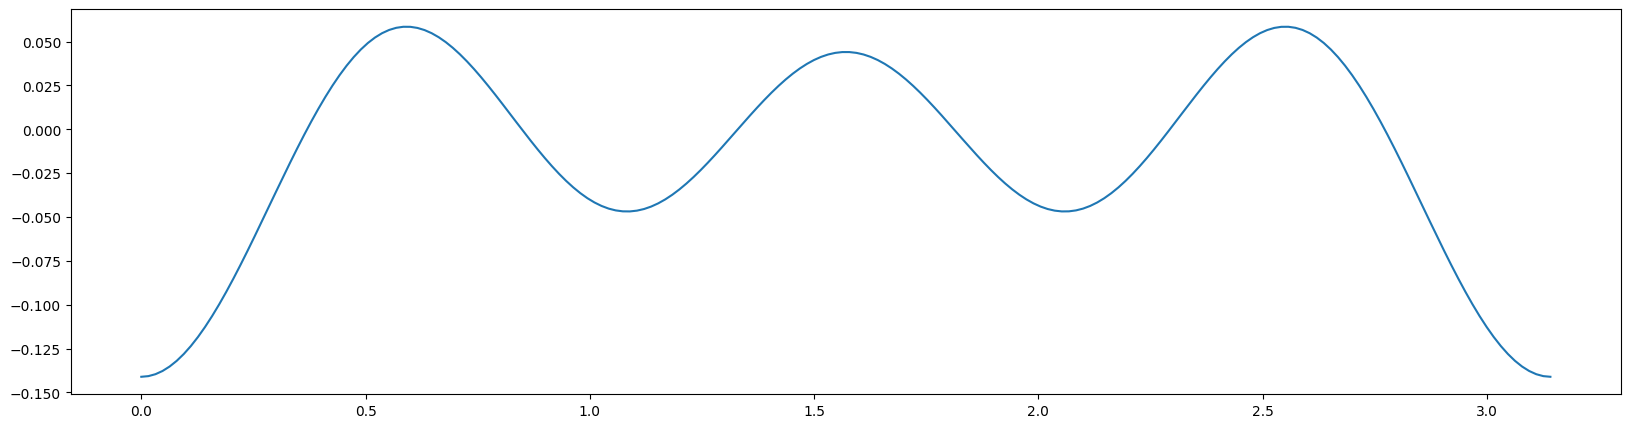

In [389]:
#Input shape parameters
modes=[(6,0),(3,1)]
amplitudes=[0.5,0]
rotation= -np.pi/2 - np.pi/20
phase=-1

#Calculating the shape
shape = make_shape(phi, theta, modes, amplitudes, rotation, phase)

(X,Y,Z) = shape
R = np.sqrt(X**2 + Y**2 + Z**2)
plt.plot(theta, R[0]-1)